
# Introduction
## File and Data Field Descriptions
From [Kaggle](https://www.kaggle.com/competitions/spaceship-titanic/data):
- **train.csv** - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
    - `PassengerId` - A unique Id for each passenger. Each Id takes the form `gggg_pp` where `gggg` indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
    - `HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.
    - `CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
    - `Cabin` - The cabin number where the passenger is staying. Takes the form `deck/num/side`, where `side` can be either `P` for *Port* or `S` for *Starboard*.
    - `Destination` - The planet the passenger will be debarking to.
    - `Age` - The age of the passenger.
    - `VIP` - Whether the passenger has paid for special VIP service during the voyage.
    - `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
    - `Name` - The first and last names of the passenger.
    - `Transported` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
- **test.csv** - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of `Transported` for the passengers in this set.
- **sample_submission.csv** - A submission file in the correct format.
    - `PassengerId` - Id for each passenger in the test set.
    - `Transported` - The target. For each passenger, predict either `True` or `False`.


# Preamble
## Import Libraries

In [208]:
from pathlib import Path
from itertools import product

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

## Settings

In [209]:
data_path = Path.cwd().joinpath("data")

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 1000)

rc = {
    "axes.spines.top": False,
    "axes.spines.right": False,
    "legend.edgecolor": "none",
}
sns.set_theme(
    context="notebook", style="whitegrid", palette="pastel", color_codes=True, rc=rc
)

# Load Data

In [210]:
train = pd.read_csv(data_path.joinpath("train.csv"))
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


Out the gate, null values are present in all columns but `PassengerId` and `Transported`.
Whether null values should be **dropped**, **ignored**, or **imputed** remains to be seen.

In [211]:
train.describe()

Age   RoomService     FoodCourt  ShoppingMall           Spa        VRDeck
count  8514.000000   8512.000000   8510.000000   8485.000000   8510.000000   8505.000000
mean     28.827930    224.687617    458.077203    173.729169    311.138778    304.854791
std      14.489021    666.717663   1611.489240    604.696458   1136.705535   1145.717189
min       0.000000      0.000000      0.000000      0.000000      0.000000      0.000000
25%      19.000000      0.000000      0.000000      0.000000      0.000000      0.000000
50%      27.000000      0.000000      0.000000      0.000000      0.000000      0.000000
75%      38.000000     47.000000     76.000000     27.000000     59.000000     46.000000
max      79.000000  14327.000000  29813.000000  23492.000000  22408.000000  24133.000000

`pandas.describe()` will be relatively un-illuminating compared to plots to come, but it is an opportunity to prepare expectations.
The `Age` **mean** and **median** (50%) are close. 
However, `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, and `VRDeck` all have a **median** of `0.0`, a **maximum** on the order of 10's of thousands, and comparatively low **means**.
The distribution of the expenses will likely need to be transformed before they are usefull.

In [212]:
train.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  Transported
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy        False
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False        109.0        9.0          25.0   549.0    44.0       Juanna Vines         True
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True         43.0     3576.0           0.0  6715.0    49.0      Altark Susent        False
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False          0.0     1283.0         371.0  3329.0   193.0       Solam Susent        False
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False        303.0       70.0         151.0   565.0     2.0  Willy Santantines         True

As mentioned in the data description at the beginning of the notebook, `PassengerId` contains group information that can be extracted and `Cabin` contains decks, numbers, and sides.

In addition, some passengers share last names in the `Name` column. Family information can be extracted.

In [213]:
test = pd.read_csv(data_path.joinpath("test.csv"))
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [214]:
test.describe()

Age   RoomService     FoodCourt  ShoppingMall           Spa        VRDeck
count  4186.000000   4195.000000   4171.000000   4179.000000   4176.000000   4197.000000
mean     28.658146    219.266269    439.484296    177.295525    303.052443    310.710031
std      14.179072    607.011289   1527.663045    560.821123   1117.186015   1246.994742
min       0.000000      0.000000      0.000000      0.000000      0.000000      0.000000
25%      19.000000      0.000000      0.000000      0.000000      0.000000      0.000000
50%      26.000000      0.000000      0.000000      0.000000      0.000000      0.000000
75%      37.000000     53.000000     78.000000     33.000000     50.000000     36.000000
max      79.000000  11567.000000  25273.000000   8292.000000  19844.000000  22272.000000

No anamolies jump out from the `test` dataset.
If features are imputed, the `train` and `test` set will be combined.
Otherwise, the `test` set will not be returned to.

# Data Validation
## Missing Values

In [215]:
train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

There are approximately 200 missing entries in each column.
It is not yet clear whether missing values are independent or random.

In [216]:
# Filter to only include rows with a null value.
# Then, sum the number of nulls in those rows.
train[train.isna().any(axis="columns")].isna().sum(axis="columns").describe()

count    2087.00000
mean        1.11356
std         0.34207
min         1.00000
25%         1.00000
50%         1.00000
75%         1.00000
max         3.00000
dtype: float64

Text(0.5, 1.0, 'Missing Values')

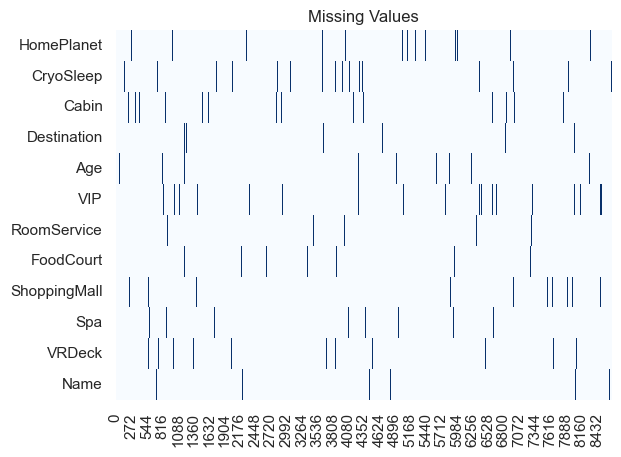

In [217]:
ax = sns.heatmap(
    train.drop(["PassengerId", "Transported"], axis="columns").isna().transpose(),
    cmap="Blues",
    cbar=False,
)
ax.set_title("Missing Values")

The vast majority of missing values appear to be found on different rows, suggesting there is no relationship between missing values.

## Duplicates

In [218]:
train[train["Name"].duplicated(keep=False) & train["Name"].notna()].sort_values("Name")

PassengerId HomePlanet CryoSleep     Cabin    Destination   Age    VIP  RoomService  FoodCourt  ShoppingMall     Spa  VRDeck                Name  Transported
7270     7775_01     Europa     False   C/253/P    55 Cancri e  28.0  False          7.0      489.0           0.0     4.0  6027.0  Alraium Disivering        False
6296     6665_01     Europa      True   B/222/P    55 Cancri e  17.0  False          0.0        0.0           0.0     0.0     0.0  Alraium Disivering         True
476      0512_02     Europa      True    D/18/S    TRAPPIST-1e  55.0  False          0.0        0.0           0.0     0.0     0.0  Ankalik Nateansive         True
2930     3176_01     Europa     False   E/196/P    TRAPPIST-1e  77.0  False          0.0     9032.0           0.0   128.0  1464.0  Ankalik Nateansive         True
8488     9071_01      Earth     False  F/1855/P    55 Cancri e  22.0  False          0.0        0.0        1072.0    46.0     3.0         Anton Woody        False
2991     3236_03      Earth     False   E/200/P    TRAPPIST-1e  18.0  False          0.0       30.0           0.0   756.0     5.0         Anton Woody        False
2559     2746_01       Mars     False   F/569/P    TRAPPIST-1e  52.0  False        758.0        0.0         356.0     5.0     0.0           Apix Wala        False
4108     4387_01       Mars     False   F/902/P  PSO J318.5-22  32.0  False        192.0        0.0         441.0    18.0     0.0           Apix Wala        False
7871     8398_01     Europa      True   B/329/S    TRAPPIST-1e  15.0  False          0.0        0.0           0.0     0.0     0.0       Asch Stradick         True
6086     6432_01     Europa     False   D/202/P    55 Cancri e  55.0  False        114.0      222.0           0.0  2575.0  2919.0       Asch Stradick        False
7862     8384_01      Earth     False  F/1722/P    TRAPPIST-1e  20.0  False          0.0        0.0           0.0  1535.0     0.0    Carry Contrevins        False
5463     5824_01      Earth      True   G/940/P    55 Cancri e  20.0  False          0.0        0.0           0.0     0.0     0.0    Carry Contrevins         True
6987     7429_01       Mars     False       NaN    TRAPPIST-1e  38.0  False       1126.0        0.0          23.0    34.0     0.0         Cuses Pread        False
6171     6513_01       Mars     False  F/1244/S    TRAPPIST-1e  20.0  False         57.0        0.0        1185.0     0.0     0.0         Cuses Pread        False
1795     1911_01      Earth     False   G/300/S    TRAPPIST-1e  46.0  False          8.0      652.0           0.0     5.0    90.0          Dia Cartez        False
4392     4663_02      Earth      True   G/765/S    TRAPPIST-1e   1.0  False          0.0        0.0           0.0     0.0     0.0          Dia Cartez         True
156      0179_01      Earth     False    G/26/P    TRAPPIST-1e  19.0  False          1.0      219.0         673.0     2.0    11.0  Elaney Webstephrey         True
956      1018_01      Earth      True   G/150/P    TRAPPIST-1e  18.0  False          0.0        0.0           0.0     0.0     0.0  Elaney Webstephrey         True
6702     7073_01      Earth      True  G/1161/S    TRAPPIST-1e  40.0  False          0.0        0.0           0.0     0.0     NaN   Glena Hahnstonsen         True
8002     8560_01      Earth      True  G/1391/P    55 Cancri e  18.0  False          0.0        0.0           0.0     0.0     0.0   Glena Hahnstonsen         True
3411     3677_01      Earth     False   F/694/S  PSO J318.5-22  24.0  False        105.0        0.0          37.0   518.0     0.0    Glenna Valezaley        False
2241     2402_01      Earth      True   G/389/P    TRAPPIST-1e  13.0  False          0.0        0.0           NaN     0.0     0.0    Glenna Valezaley        False
2852     3081_01     Europa     False   C/118/S    55 Cancri e  50.0  False          0.0     1547.0           0.0  1784.0     1.0      Gollux Reedall         True
827      0881_01     Europa     False    D/32/S    TRAPPIST-1e  41.0  False       3103.0     

Some passengers who share names are not likley to be duplicates.
Consider Glena Hahnstonsen, listed 18 and 40, with two different desinations.

However, some passenegers are likely to be duplicates. 
Consider Elaney Webstrephtey, traveling from Earth to TRAPPIST-1e. At one entry, aged 19, at another, 18. 

In most cases, if one passenger had any charges to their account, the possible duplicate did not.
Without more information about how the data were collected, it is difficult to draw conclutions.

The most likey candidates would be those with the same name, home planet, and destination.
It would also be expected that their ages would be close.
Regardless, as shown below, there do not appear to be many possible duplicates.

In [219]:
train[
    (
        train.duplicated(subset=["Name", "HomePlanet", "Destination"], keep=False)
        & train["Name"].notna()
    )
].sort_values("Name")[["Name", "HomePlanet", "Destination", "Cabin", "Age"]]

Name HomePlanet  Destination     Cabin   Age
7270  Alraium Disivering     Europa  55 Cancri e   C/253/P  28.0
6296  Alraium Disivering     Europa  55 Cancri e   B/222/P  17.0
476   Ankalik Nateansive     Europa  TRAPPIST-1e    D/18/S  55.0
2930  Ankalik Nateansive     Europa  TRAPPIST-1e   E/196/P  77.0
6987         Cuses Pread       Mars  TRAPPIST-1e       NaN  38.0
6171         Cuses Pread       Mars  TRAPPIST-1e  F/1244/S  20.0
1795          Dia Cartez      Earth  TRAPPIST-1e   G/300/S  46.0
4392          Dia Cartez      Earth  TRAPPIST-1e   G/765/S   1.0
156   Elaney Webstephrey      Earth  TRAPPIST-1e    G/26/P  19.0
956   Elaney Webstephrey      Earth  TRAPPIST-1e   G/150/P  18.0
3291         Grake Porki       Mars  TRAPPIST-1e   F/668/S  25.0
838          Grake Porki       Mars  TRAPPIST-1e   F/167/S  32.0
3309       Gwendy Sykess      Earth  TRAPPIST-1e   F/735/P  28.0
1292       Gwendy Sykess      Earth  TRAPPIST-1e   F/267/S  19.0
7495   Juane Popelazquez      Earth  TRAPPIST-1e  F/1532/S  54.0
3534   Juane Popelazquez      Earth  TRAPPIST-1e   G/620/S  15.0
5432        Keitha Josey      Earth  TRAPPIST-1e   G/934/P   2.0
220         Keitha Josey      Earth  TRAPPIST-1e    F/50/P  43.0
4730     Loree Wolfernan      Earth  TRAPPIST-1e  F/1028/P  31.0
7650     Loree Wolfernan      Earth  TRAPPIST-1e  G/1314/S  31.0
2700     Sharie Gallenry      Earth  55 Cancri e   G/469/P   0.0
1812     Sharie Gallenry      Earth  55 Cancri e   G/307/S  18.0
4217          Sus Coolez      Earth  TRAPPIST-1e   F/845/S  26.0
2883          Sus Coolez      Earth  TRAPPIST-1e   G/510/P  28.0

# Feature Engineering
## Feature Extraction

The description of the data alluded to various features that could be extracted from existing columns:
- `PassengerId`: Passenger Group and the Passenger's number within the group
- `Name`: The first and last name of the passenger
- `Cabin`: Deck, Number, and side in which the passenger stayed

After those features are extracted, the original columns will be removed under the assumption all valuable information has been preserved.

In [220]:
# Extract Passenger Group and Passenger Number from the PassengerId
# gggg_pp
train[["PassengerGroup", "PassengerNumber"]] = (
    train["PassengerId"].str.extract(r"^(?P<Group>\d{4})_(?P<Number>\d{2})").astype(int)
)
# Confirm no null values were generated by this extraction
train[["PassengerGroup", "PassengerNumber"]].isna().sum()

PassengerGroup     0
PassengerNumber    0
dtype: int64

In [221]:
# Extract First and Last name from the Name column
train[["FirstName", "LastName"]] = train["Name"].str.extract(
    r"^(?P<First>\w*)\s*(?P<Last>\w*)$"
)
# Ensure no *additional* null values were generated by this extraction
np.sum(train[["FirstName", "LastName"]].isna().index != train[["Name"]].isna().index)

0

In [222]:
# Extract Deck, Number, and Side from the Cabin column
train[["CabinDeck", "CabinNumber", "CabinSide"]] = (
    train["Cabin"]
    .str.extract(r"^(?P<Deck>\w)\/(?P<Number>\w*)\/(?P<Side>\w)$")
    .replace({"P": "Port", "S": "Starboard"})
)
# Ensure no *additional* null values were generated by this extraction
np.sum(
    train[["CabinDeck", "CabinNumber", "CabinSide"]].isna().index
    != train[["Cabin"]].isna().index
)

0

## Feature Construction

In **Feature Extraction**, the `GroupNumber` and `LastName` of each passenger was extracted.
It is possible there is a covariance between members of the same group and family.
Additionally, different sizes of each may play a part in how likly someone was to be **Transported**.

In [223]:
train = train.merge(
    train["PassengerGroup"].value_counts().rename("GroupSize"),
    how="left",
    left_on="PassengerGroup",
    right_index=True,
)

In [224]:
train = train.merge(
    train["LastName"].value_counts().rename("FamilySize"),
    how="left",
    left_on="LastName",
    right_index=True,
)

In [225]:
train = train.merge(
    train["Cabin"].value_counts().rename("CabinSize"),
    how="left",
    left_on="Cabin",
    right_index=True,
)

In [226]:
train = train.drop(["PassengerId", "Name", "Cabin"], axis="columns")

# Exploratory Data Analysis

In [227]:
categorical_features = [
    "PassengerNumber",
    "GroupSize",
    "FamilySize",
    "CabinSize",
    "HomePlanet",
    "CryoSleep",
    "CabinDeck",
    "CabinSide",
    "Destination",
    "VIP",
]

numerical_features = [
    "PassengerGroup",
    "Age",
]

log_numerical_features = [
    "RoomService",
    "FoodCourt",
    "ShoppingMall",
    "Spa",
    "VRDeck",
]

label = "Transported"

## Tranported Rate
As shown below, about %49 of passengers were transported.
The label in this case is reasonably balanced.

Text(0.5, 1.0, 'Transported Count')

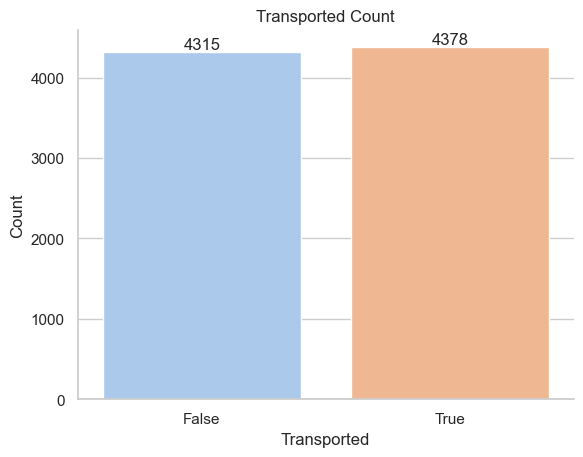

In [228]:
ax = sns.countplot(train, x=label)
for container in ax.containers:
    ax.bar_label(container, label_type="edge")
ax.set_ylabel("Count")
ax.set_title(f"{label} Count")

## Categorical Relationship to Label

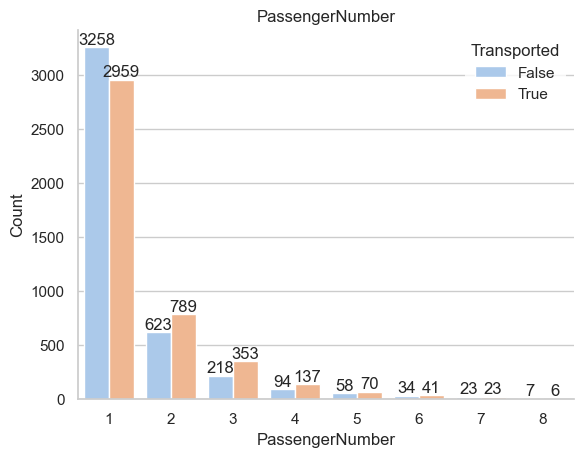

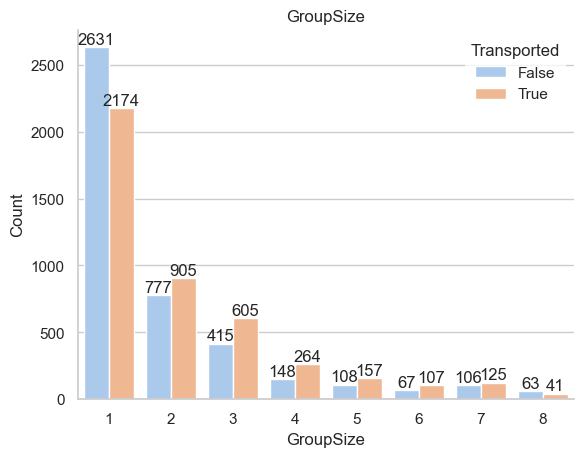

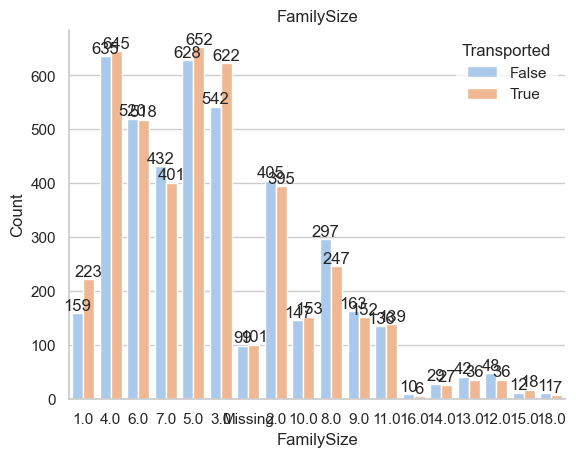

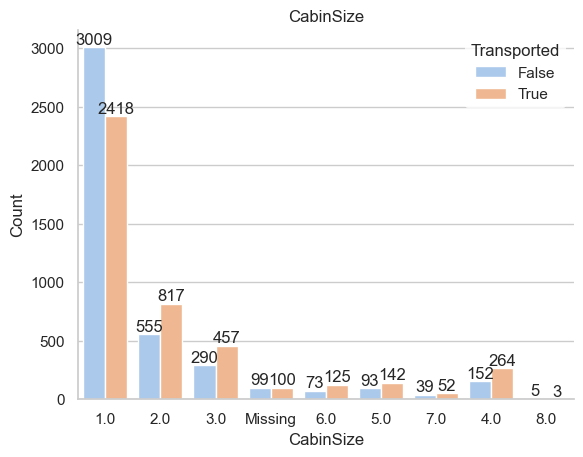

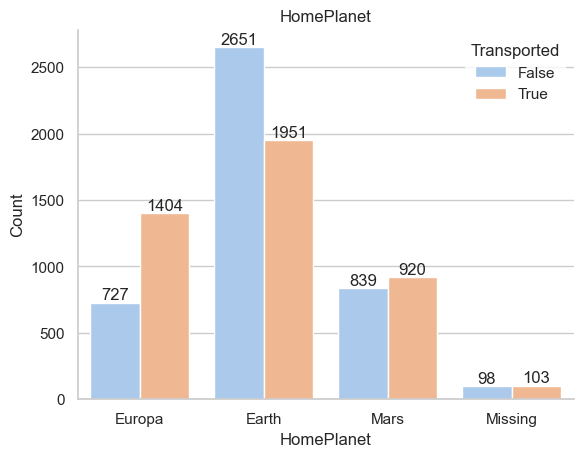

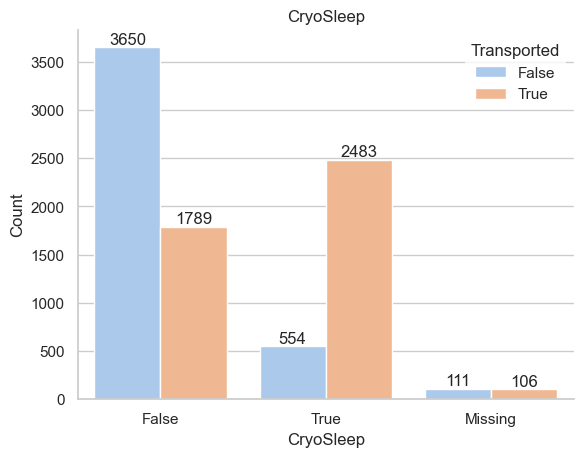

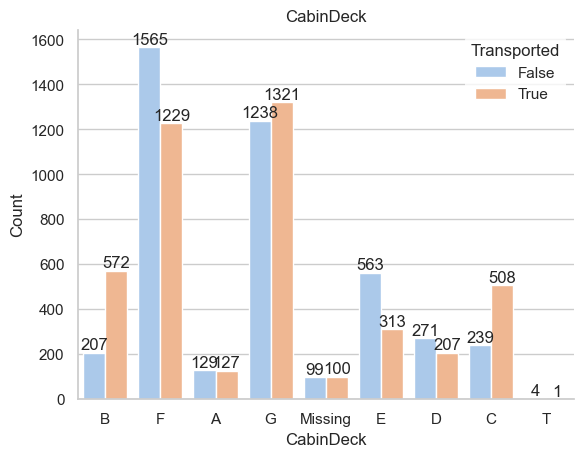

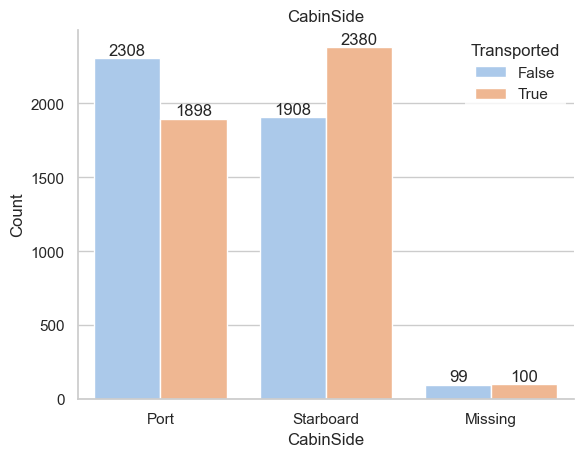

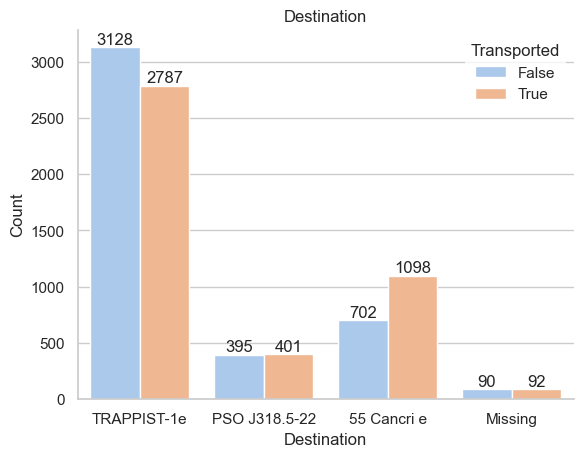

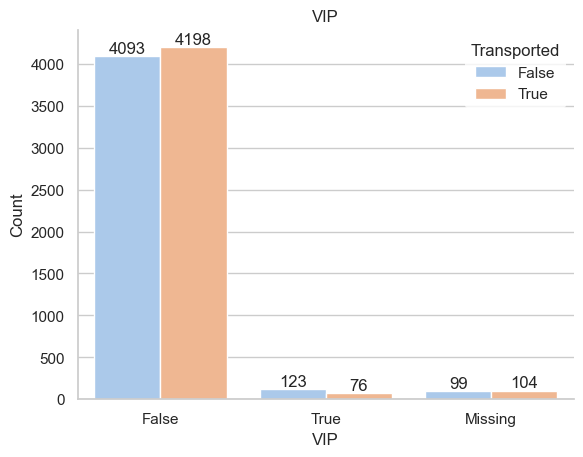

In [229]:
for feature in categorical_features:
    ax = sns.countplot(train.fillna("Missing"), x=feature, hue=label)
    for bar in ax.containers:
        ax.bar_label(bar, label_type="edge")
    ax.set_ylabel("Count")
    ax.set_title(feature)
    plt.show()

## Numerical Relationship to Label

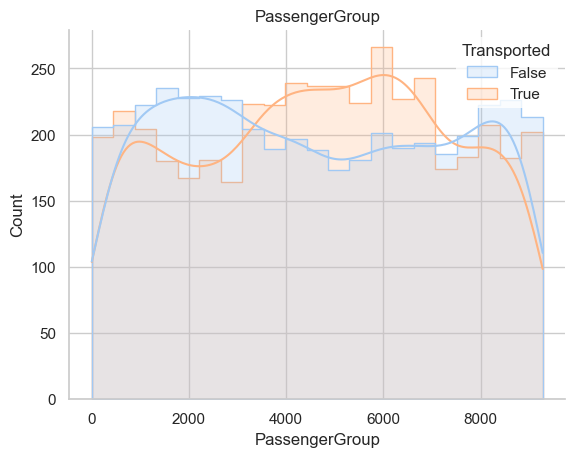

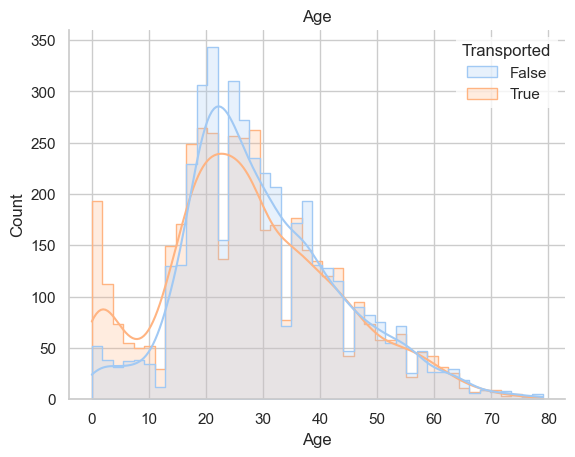

In [230]:
for feature in numerical_features:
    ax = sns.histplot(data=train, x=feature, hue=label, element="step", kde=True)
    ax.set_title(feature)
    plt.show()

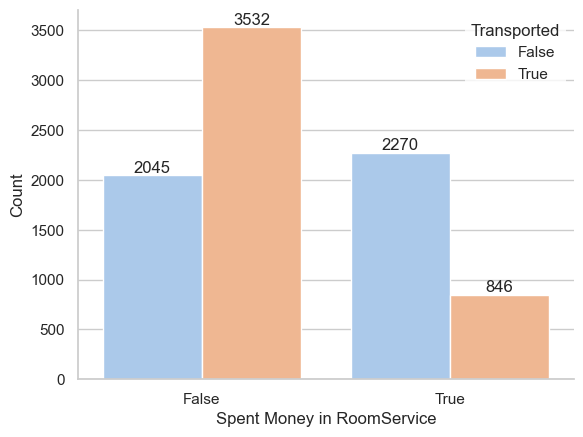

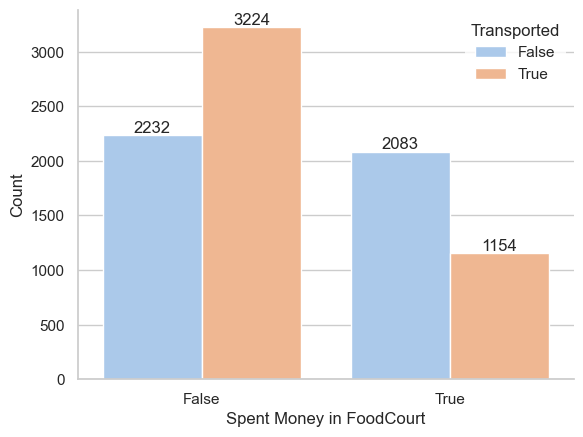

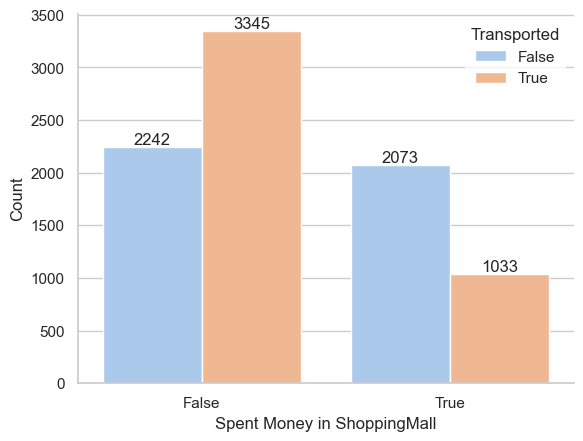

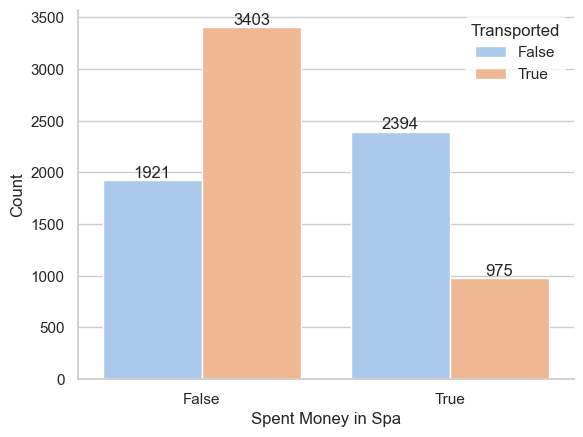

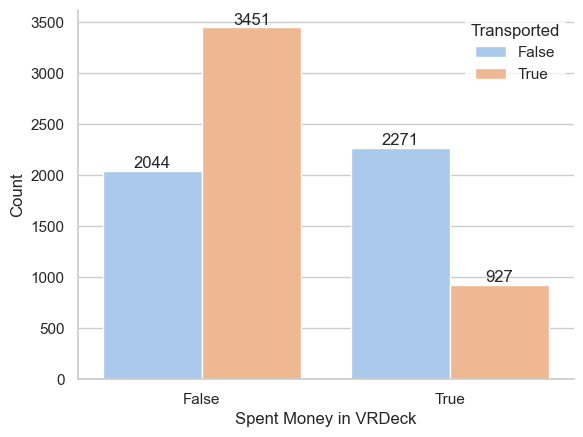

In [231]:
# Note: Missing values are being treated as 0
for feature in log_numerical_features:
    ax = sns.countplot(train[[feature, label]].astype(bool), x=feature, hue=label)
    for bar in ax.containers:
        ax.bar_label(bar, label_type="edge")
    ax.set_xlabel(f"Spent Money in {feature}")
    ax.set_ylabel("Count")
    plt.show()

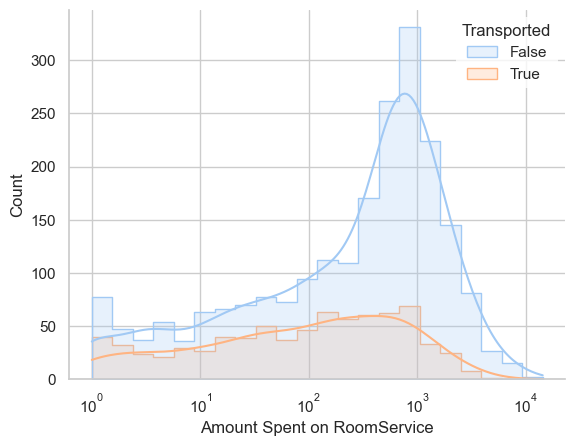

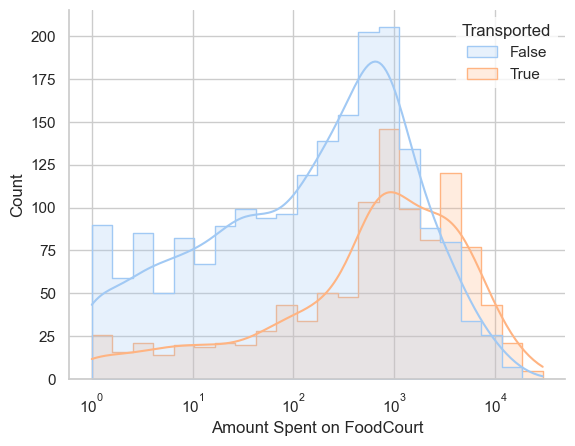

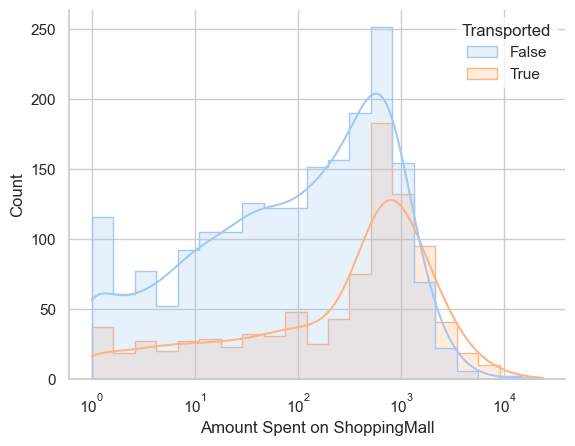

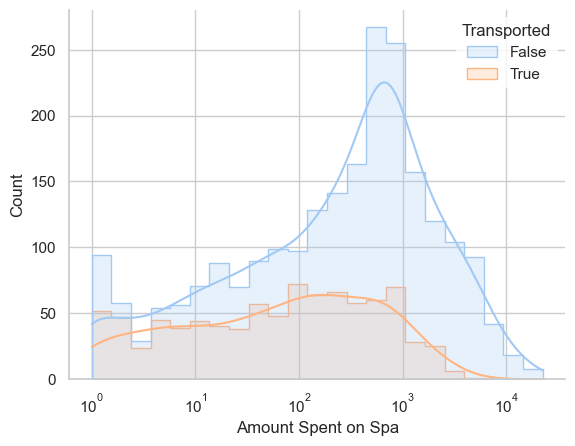

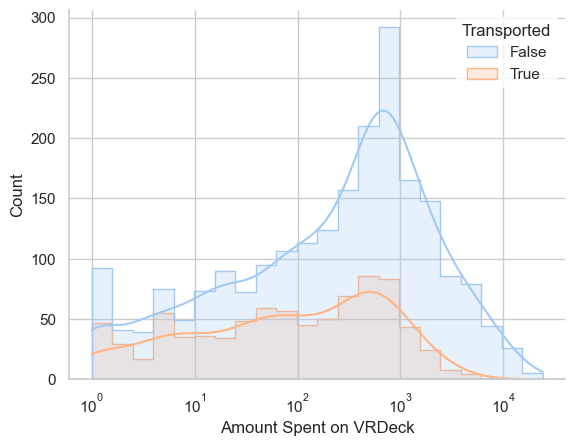

In [232]:
for feature in log_numerical_features:
    ax = sns.histplot(
        data=train[train[feature] > 0],
        x=feature,
        hue=label,
        element="step",
        kde=True,
        log_scale=True,
    )
    ax.set_xlabel(f"Amount Spent on {feature}")
    plt.show()

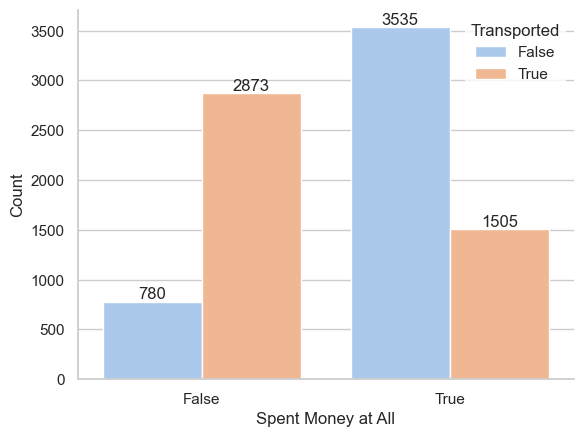

In [233]:
ax = sns.countplot(
    x=train[log_numerical_features].sum(axis=1).dropna().astype(bool), hue=train[label]
)
for bar in ax.containers:
    ax.bar_label(bar, label_type="edge")
ax.set_xlabel(f"Spent Money at All")
ax.set_ylabel("Count")
plt.show()

Text(0.5, 0, 'Amount Spent Overall')

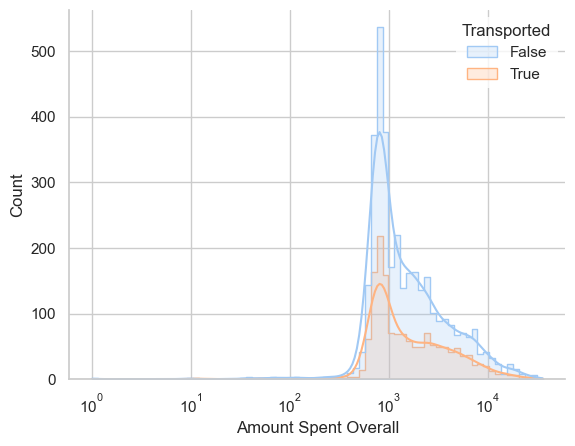

In [234]:
ax = sns.histplot(
    x=train[log_numerical_features].sum(axis=1)[
        train[log_numerical_features].sum(axis=1) > 0
    ],
    hue=train[label],
    element="step",
    kde=True,
    log_scale=True,
)
ax.set_xlabel(f"Amount Spent Overall")

## Covariance

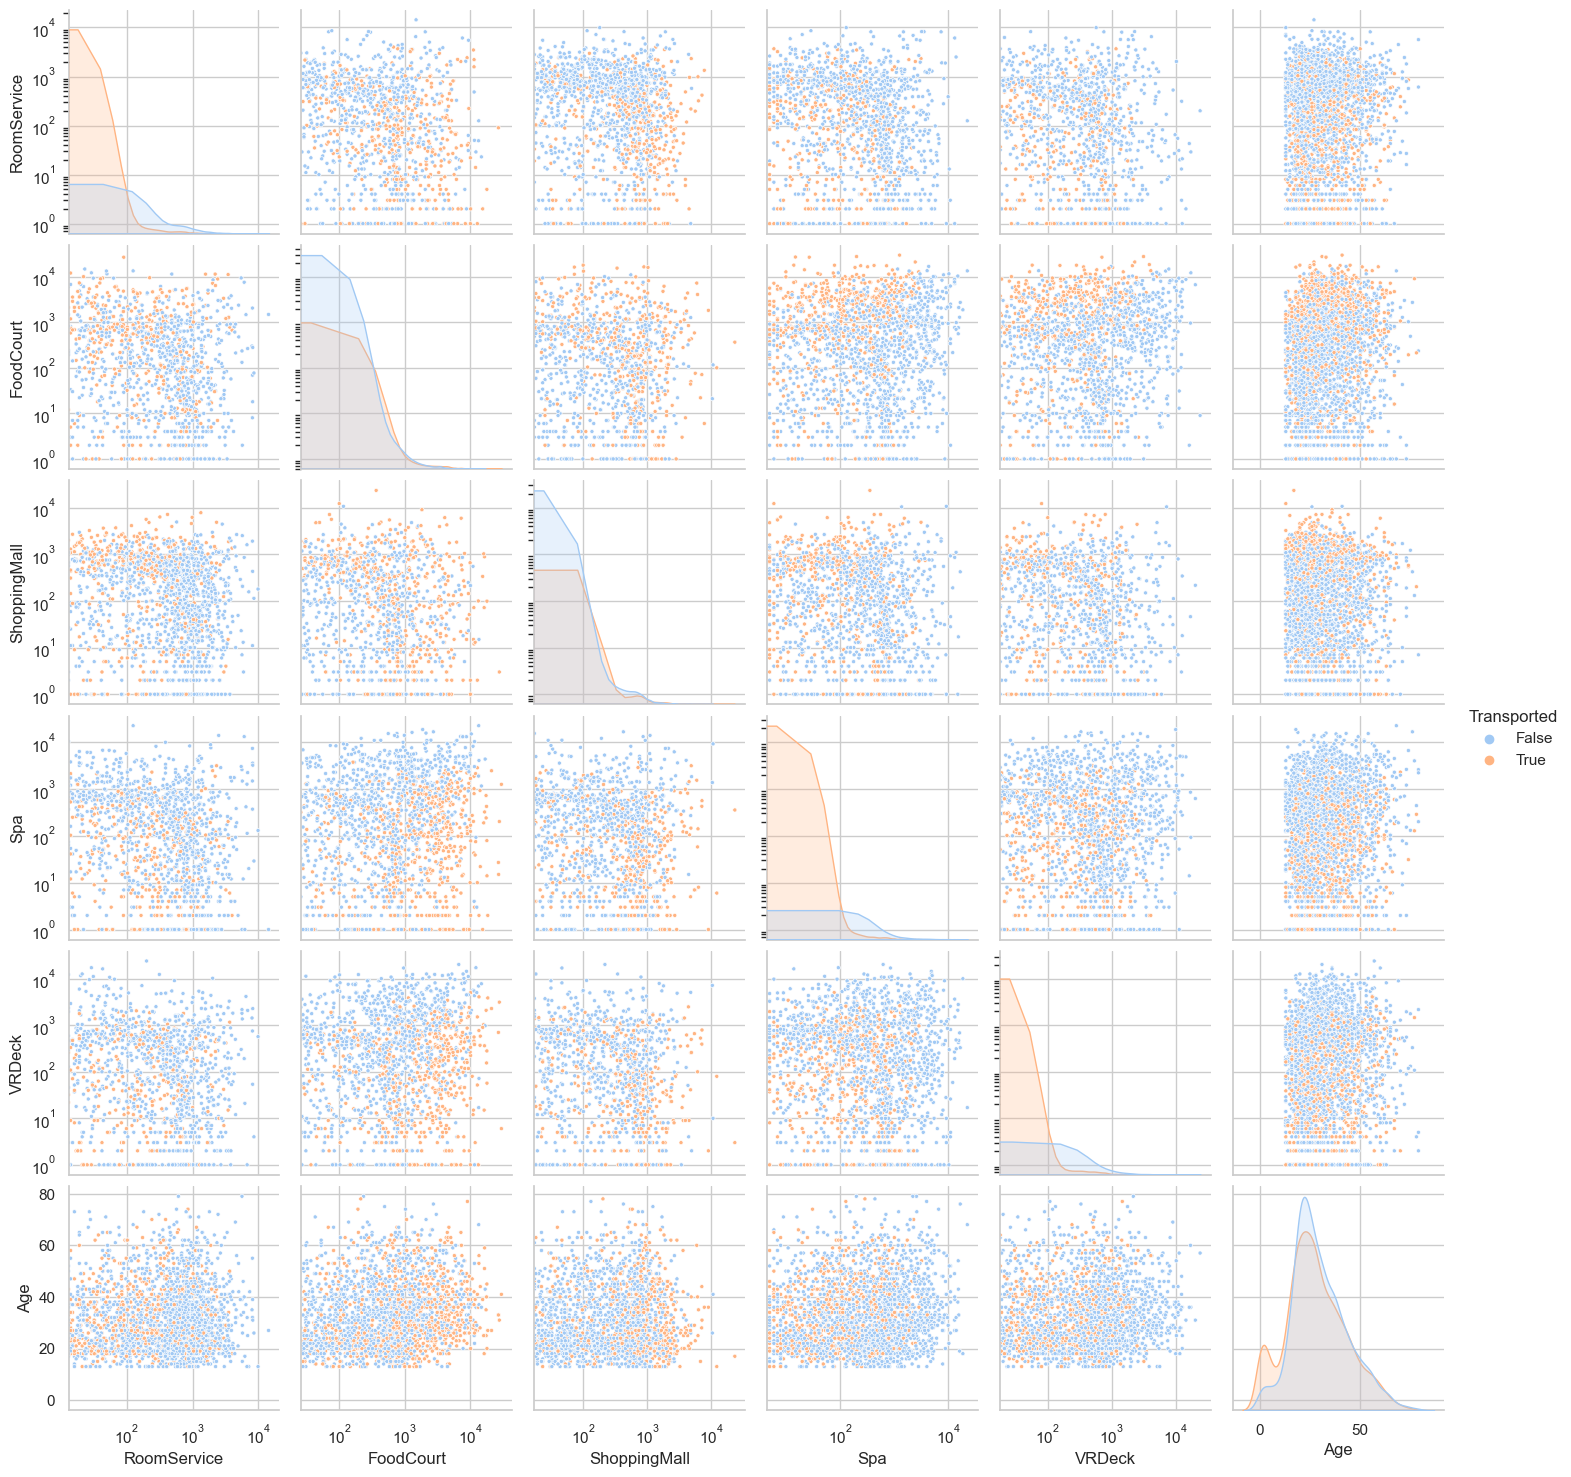

In [235]:
pp = sns.pairplot(train, vars=log_numerical_features + ["Age"], markers=".", hue=label)
for ax in pp.axes.flat:
    if ax.get_xlabel() in log_numerical_features:
        ax.set(xscale="log")
    if ax.get_ylabel() in log_numerical_features:
        ax.set(yscale="log")

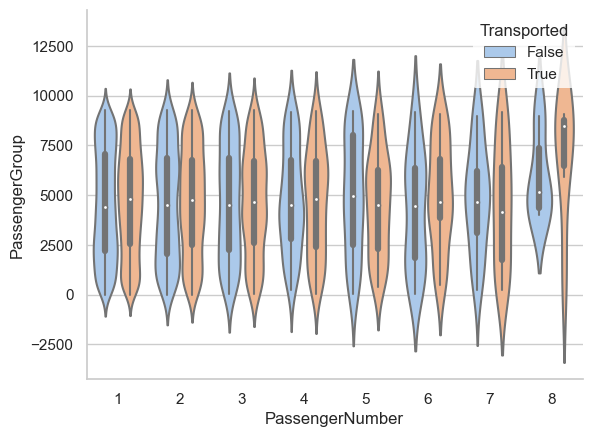

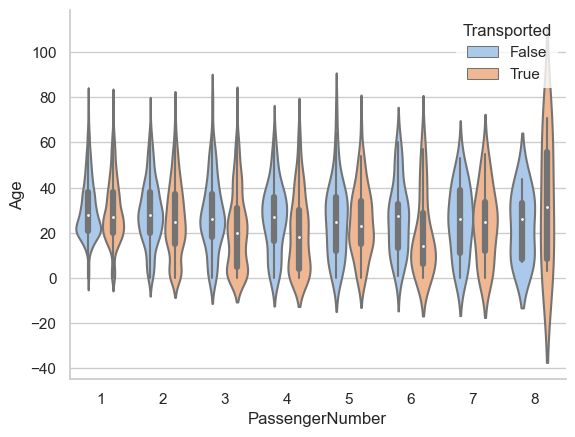

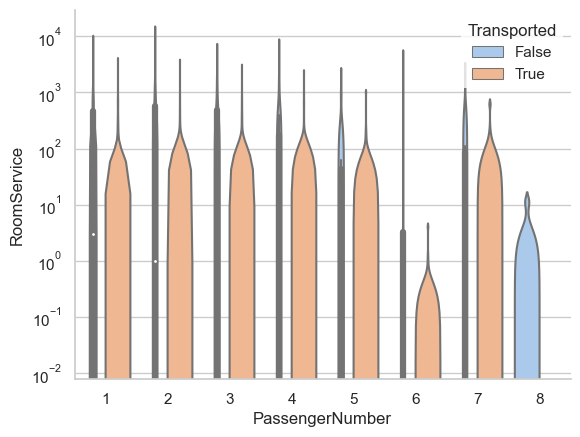

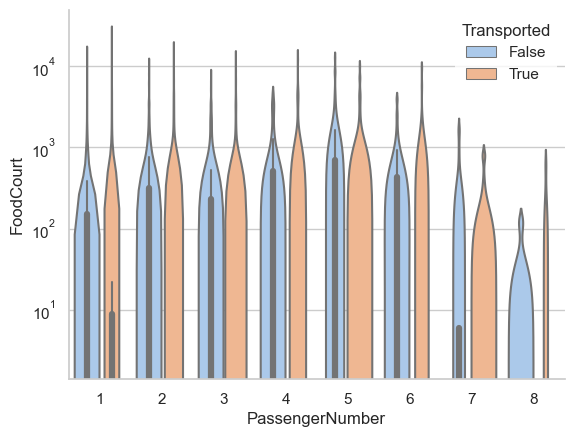

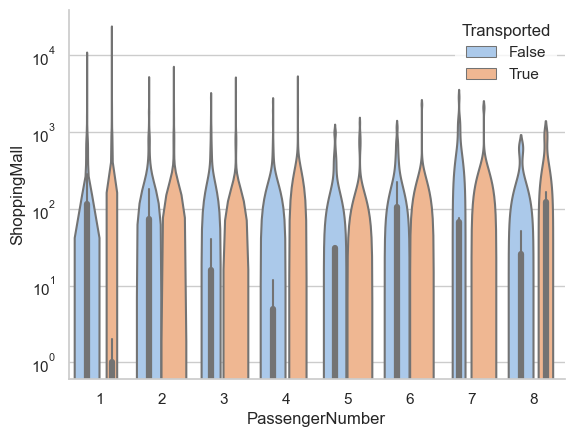

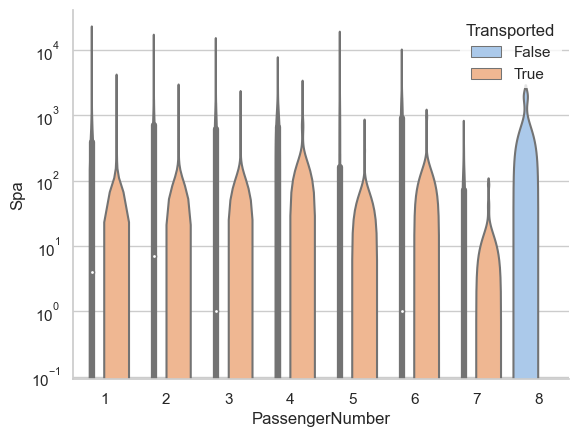

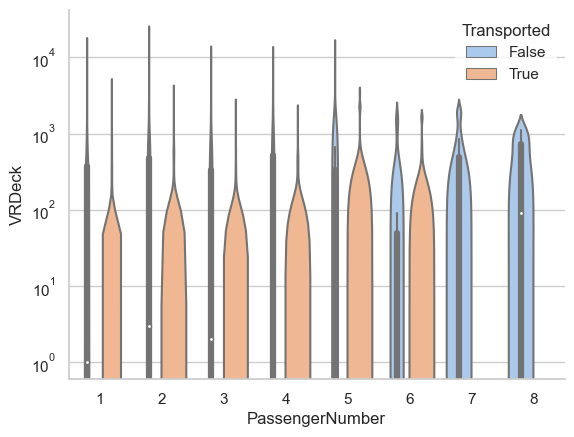

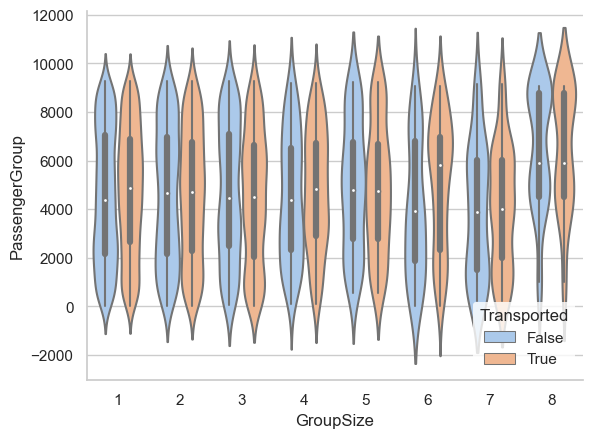

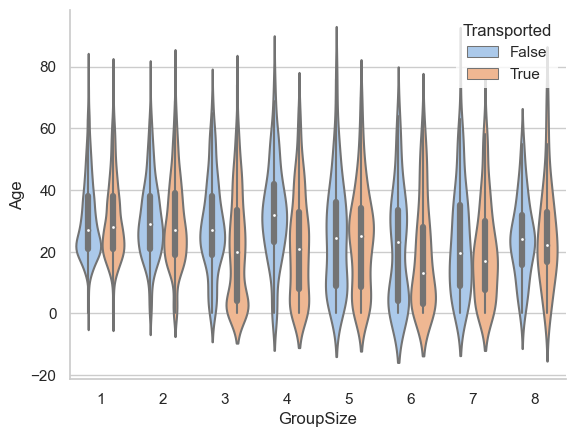

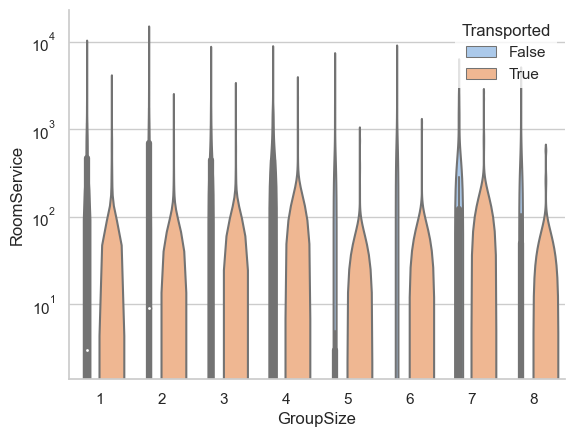

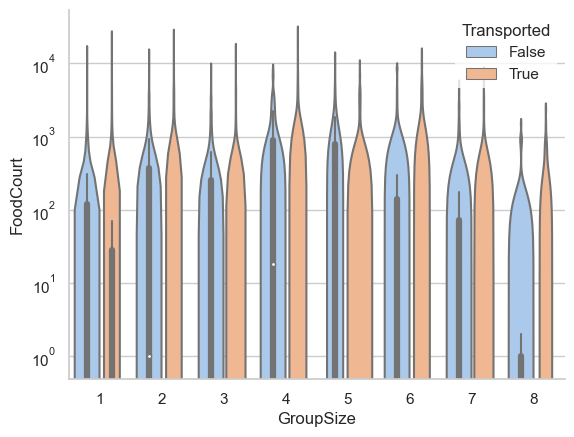

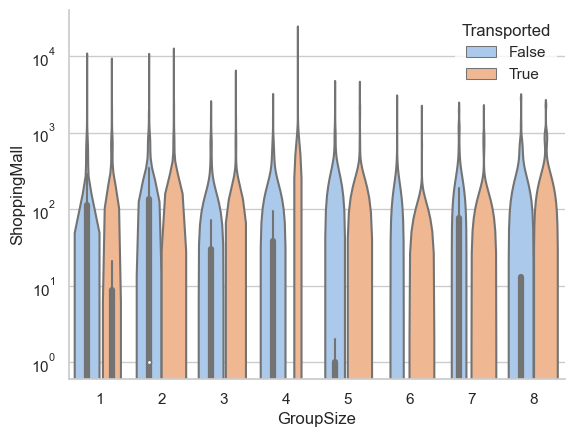

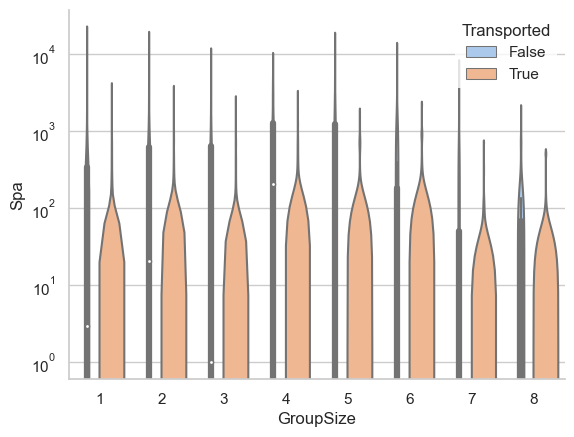

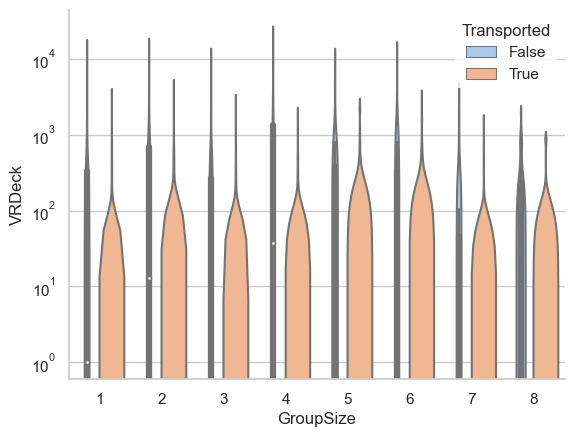

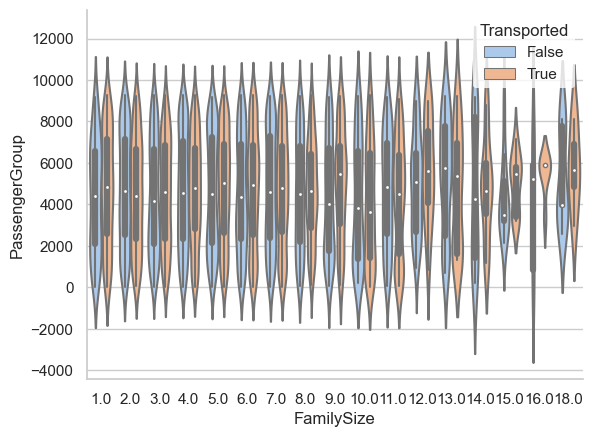

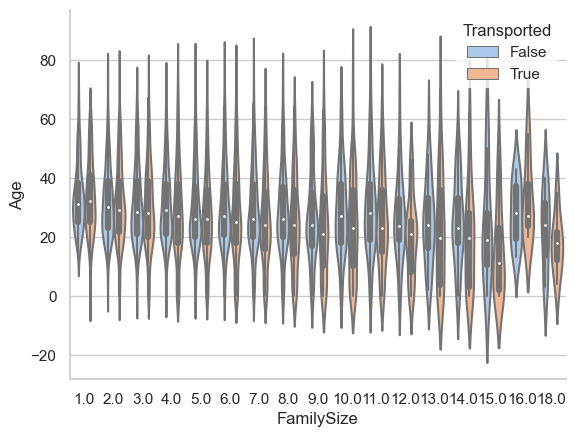

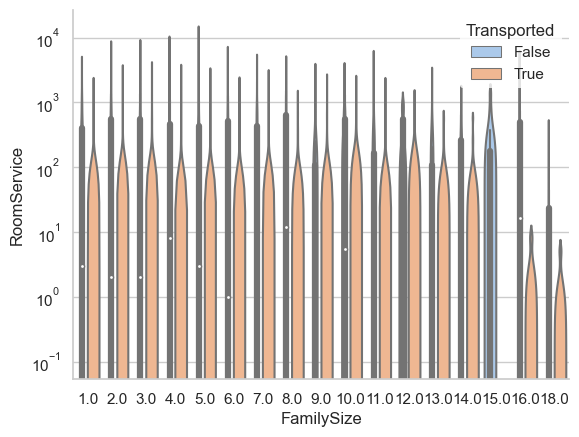

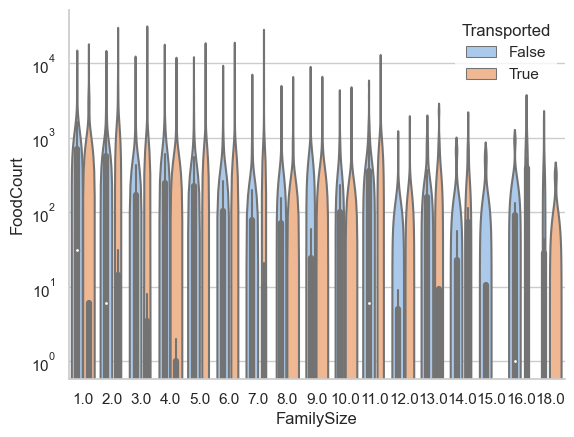

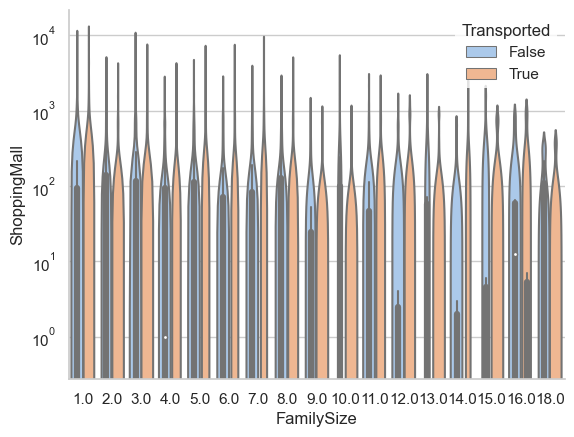

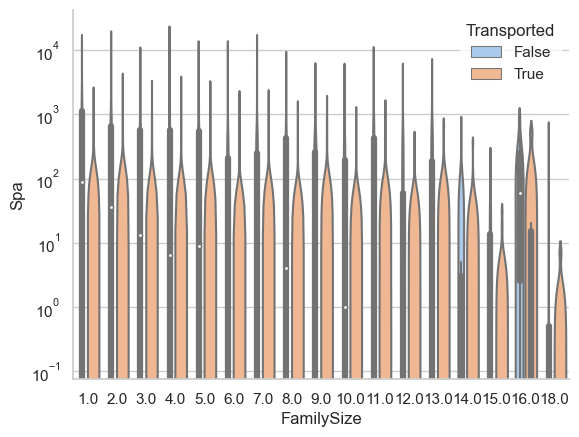

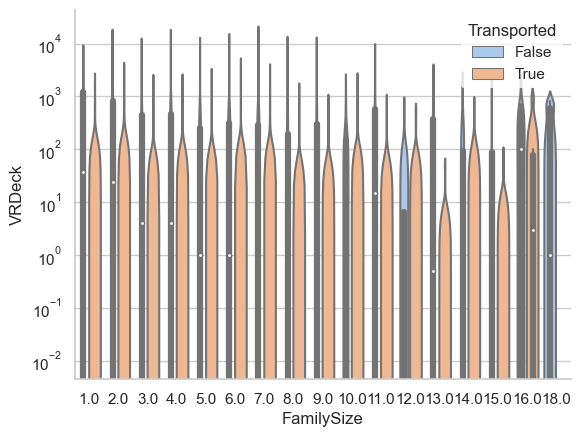

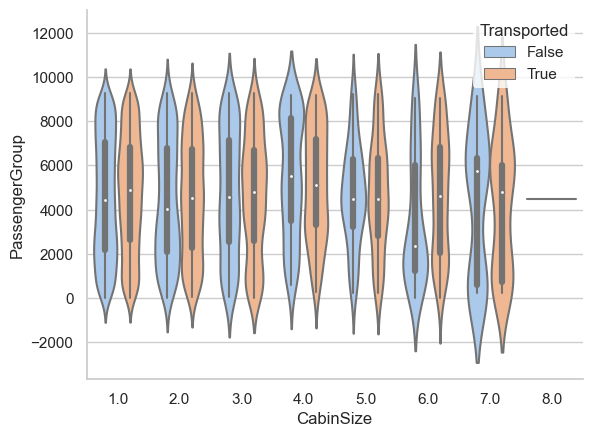

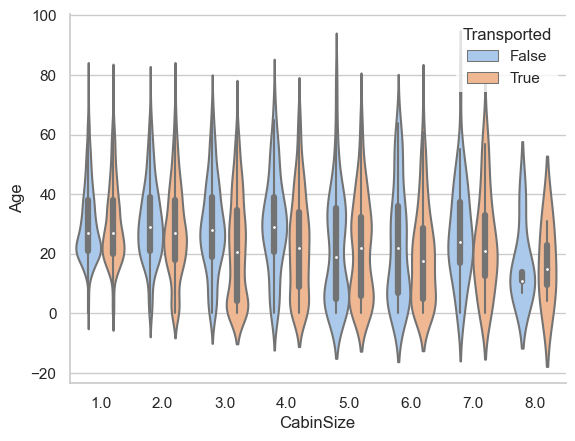

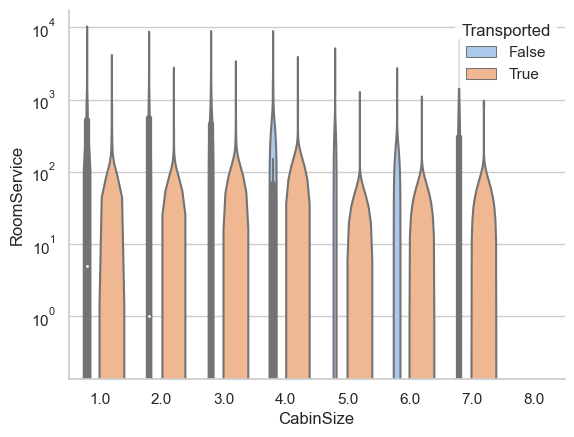

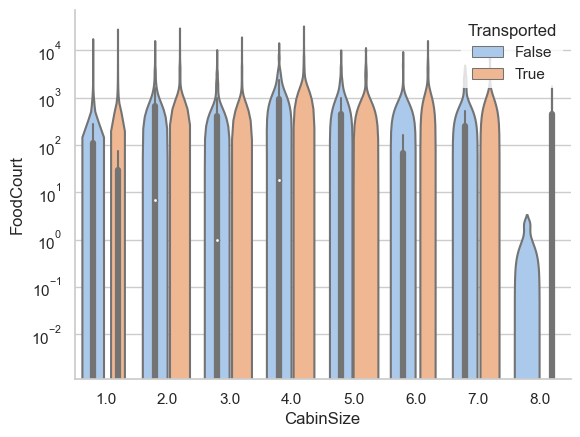

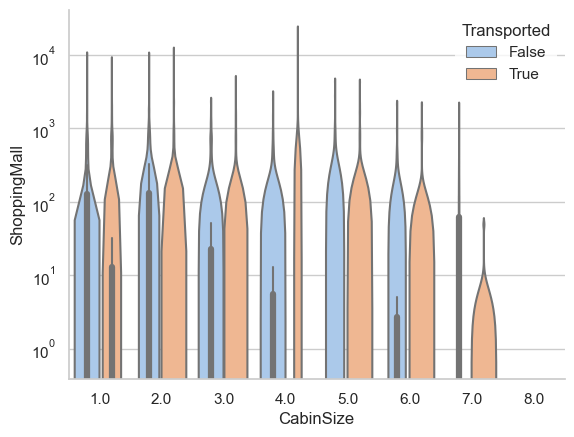

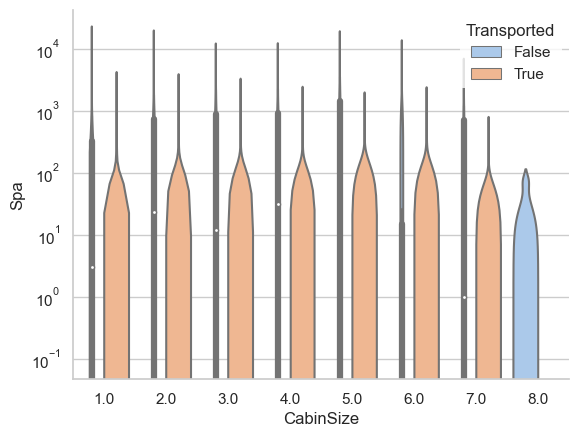

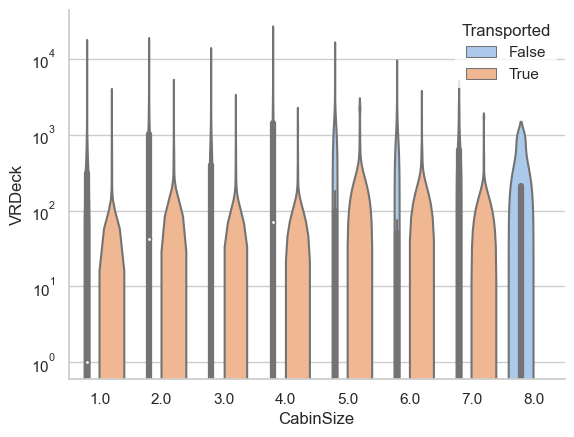

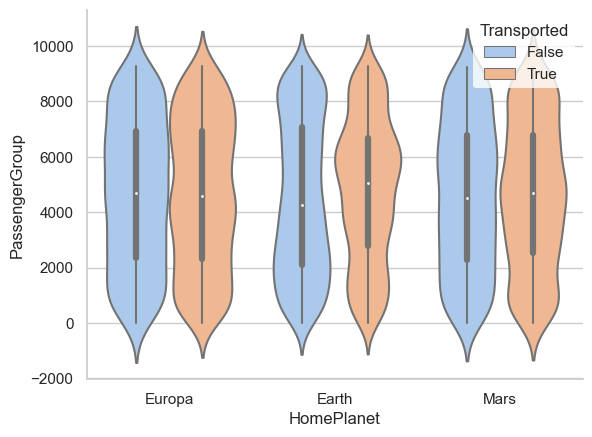

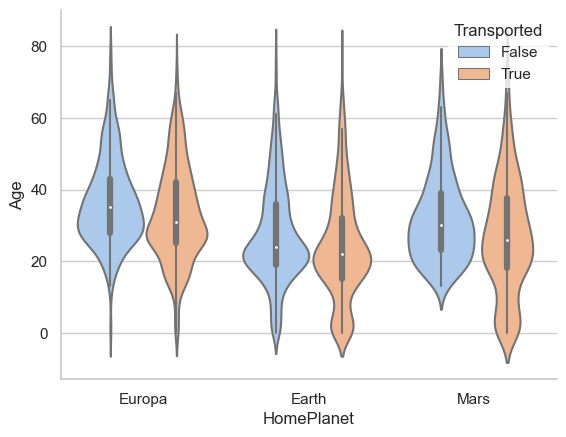

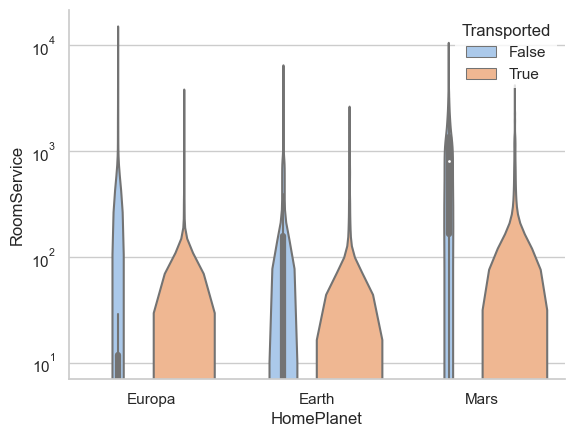

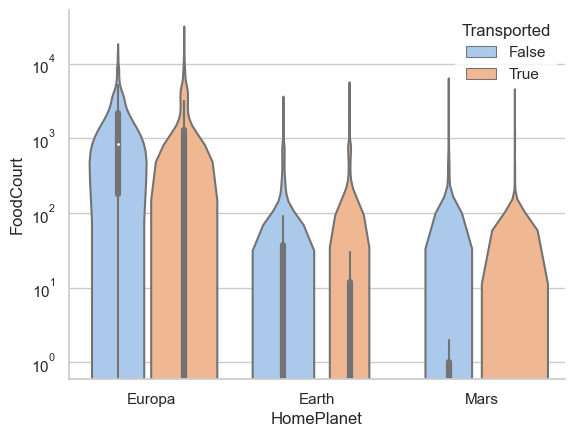

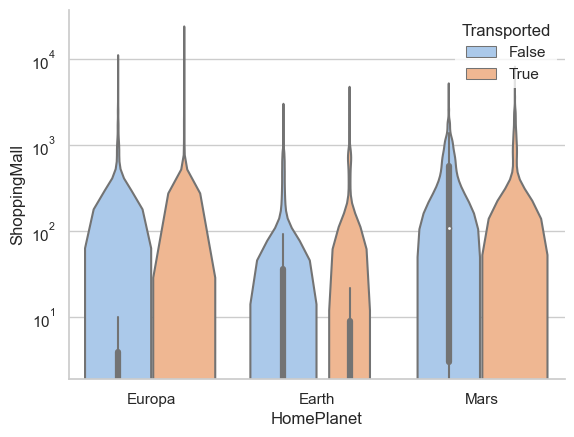

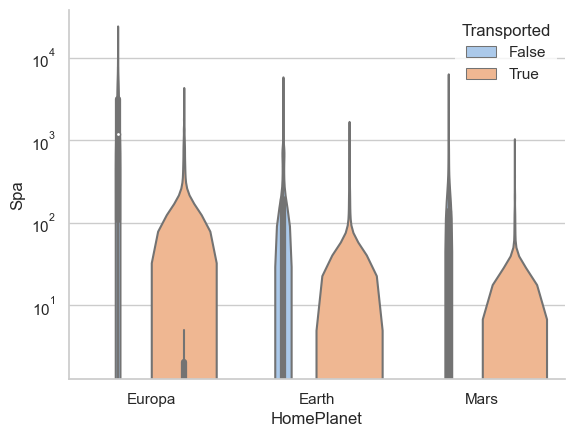

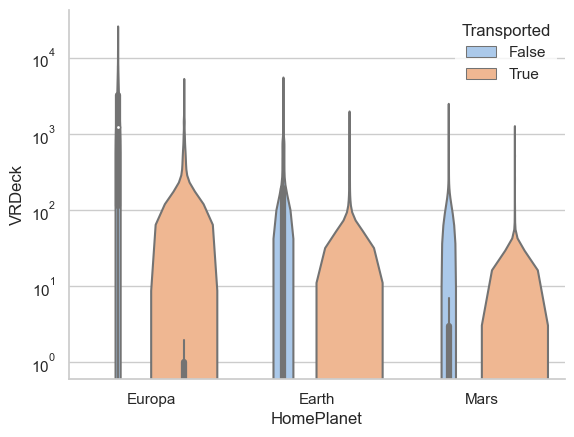

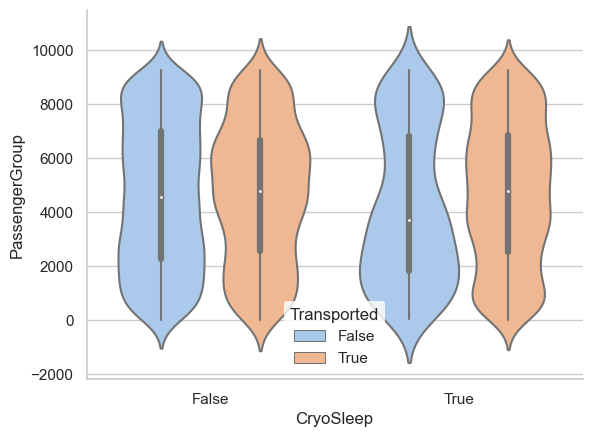

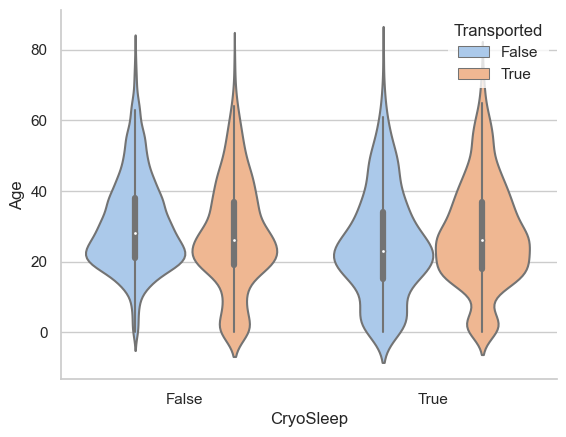

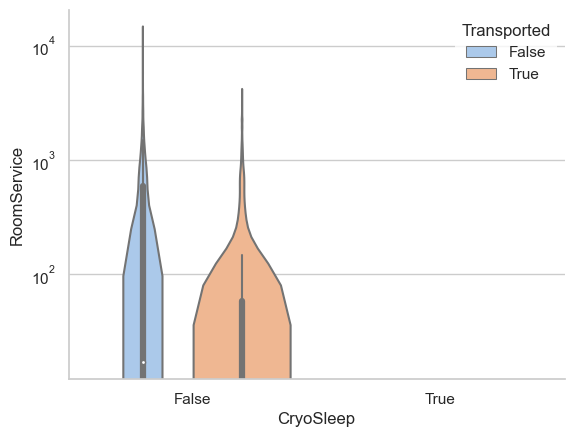

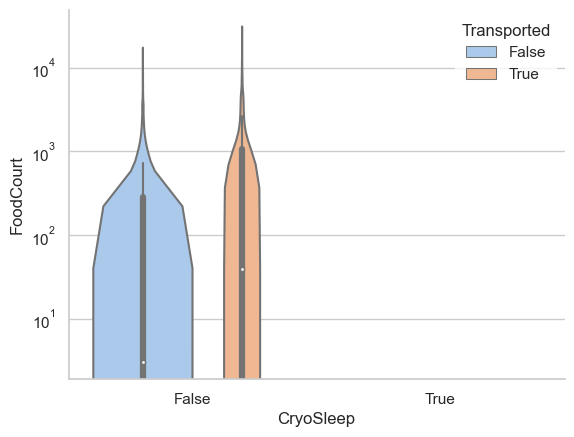

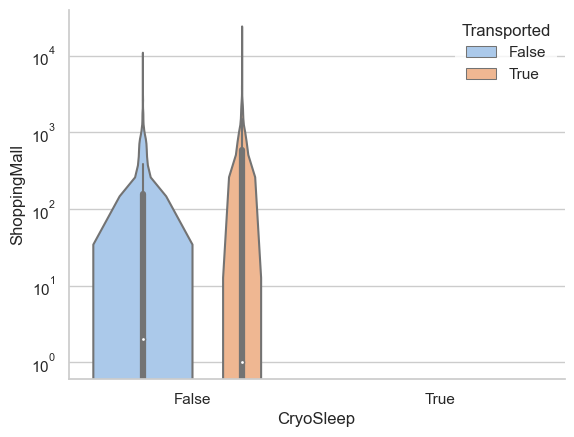

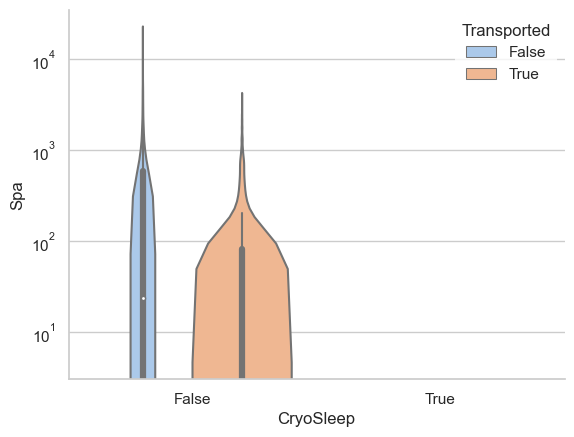

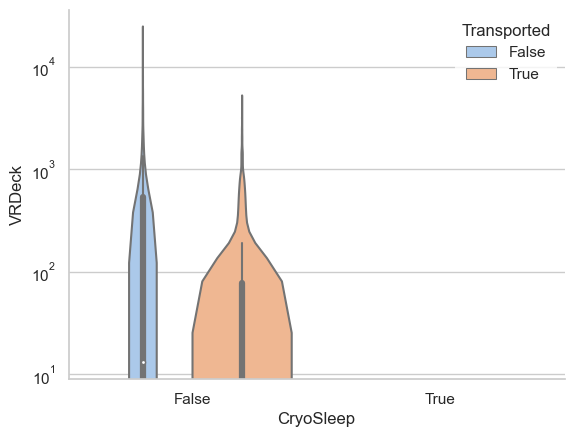

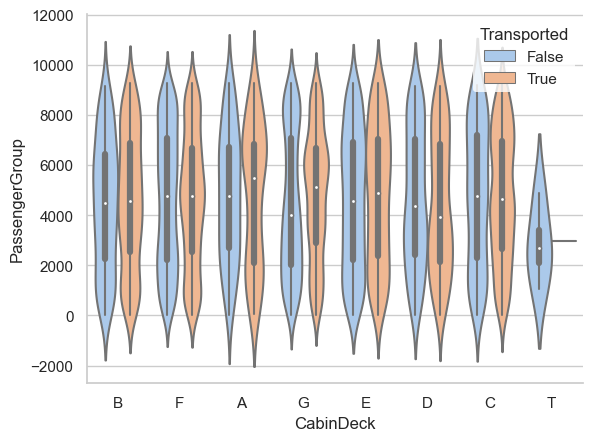

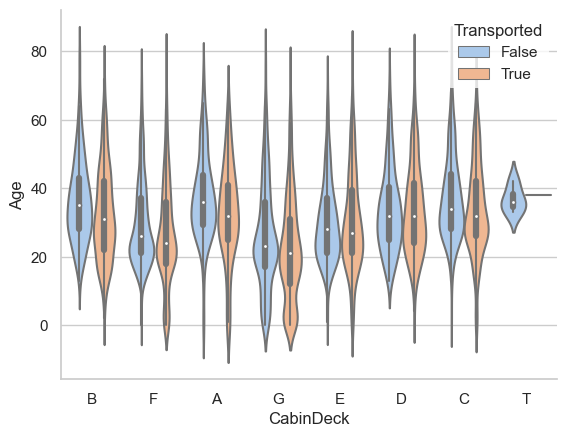

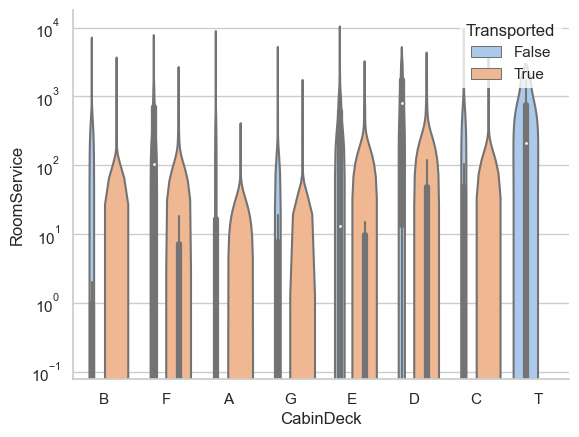

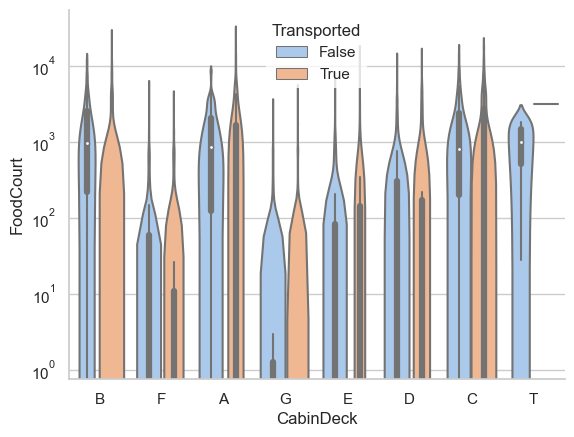

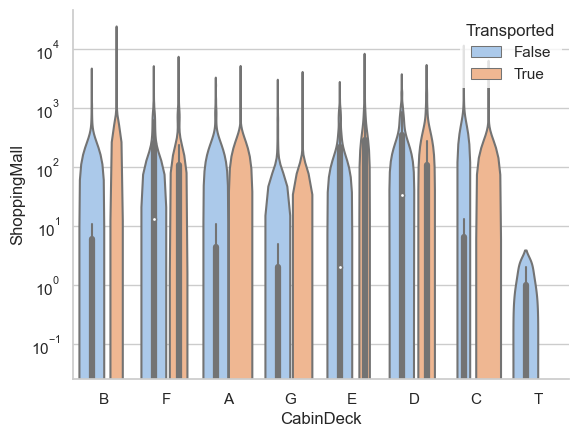

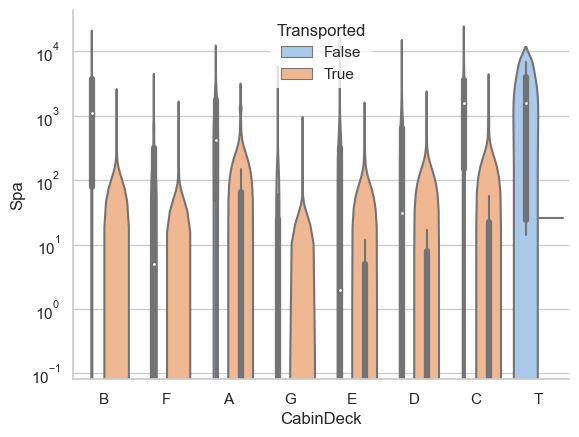

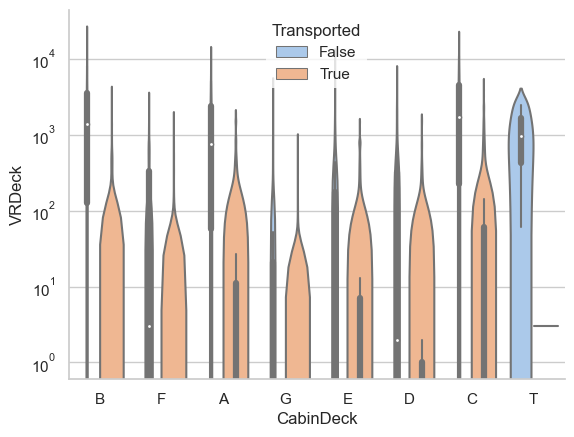

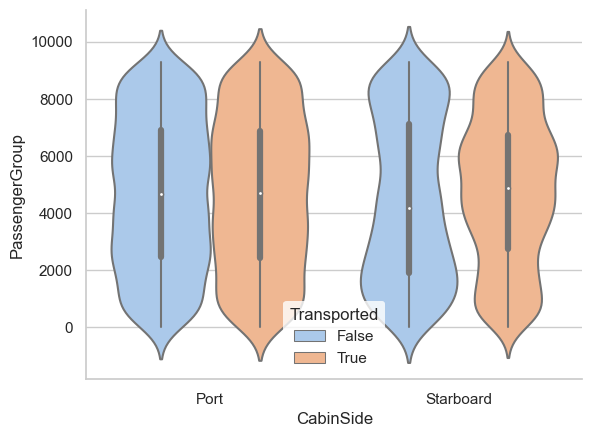

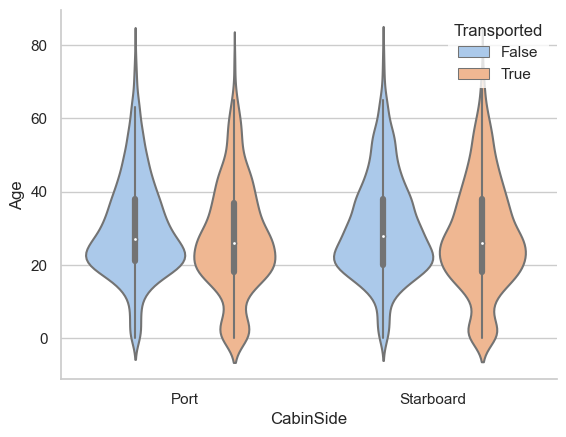

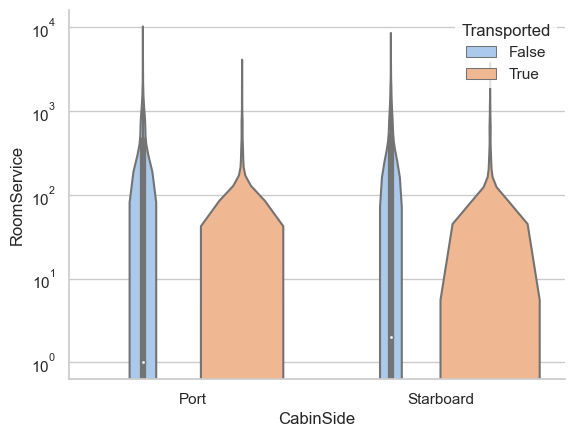

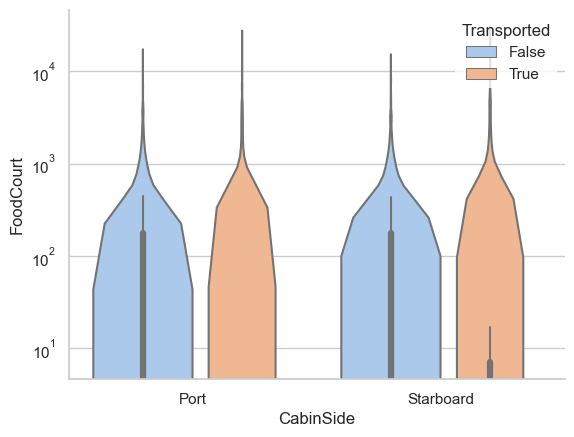

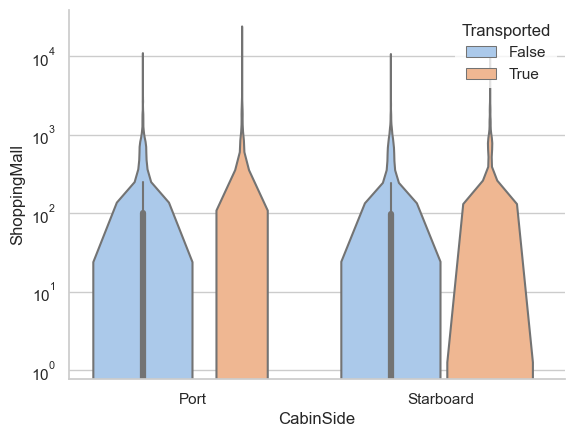

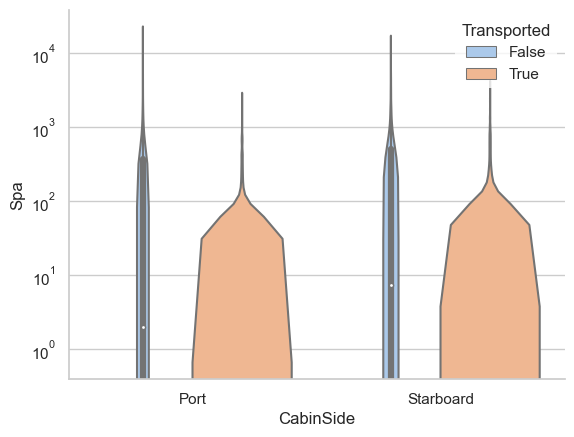

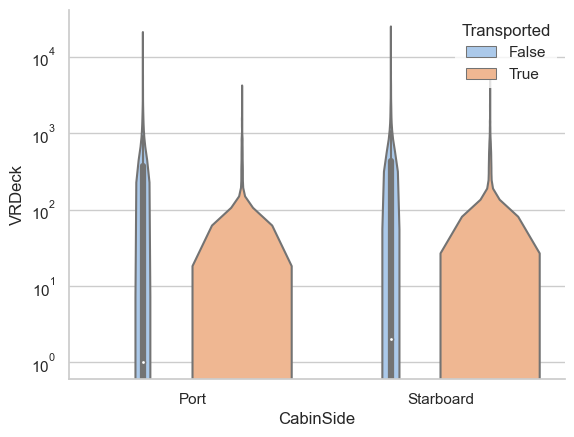

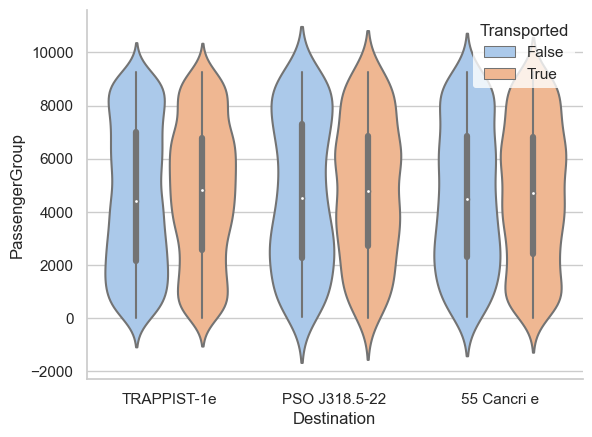

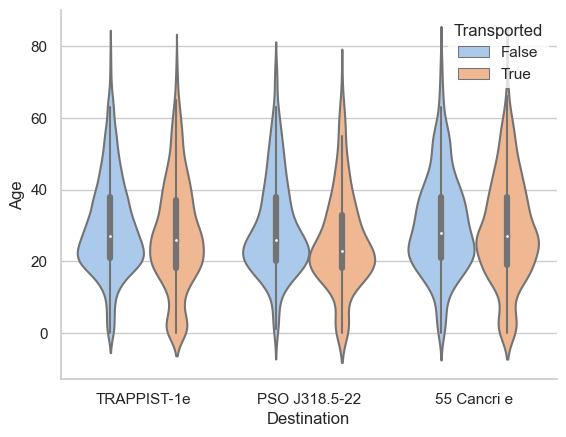

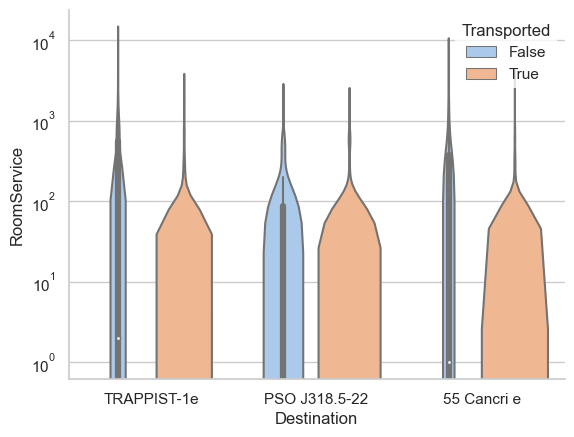

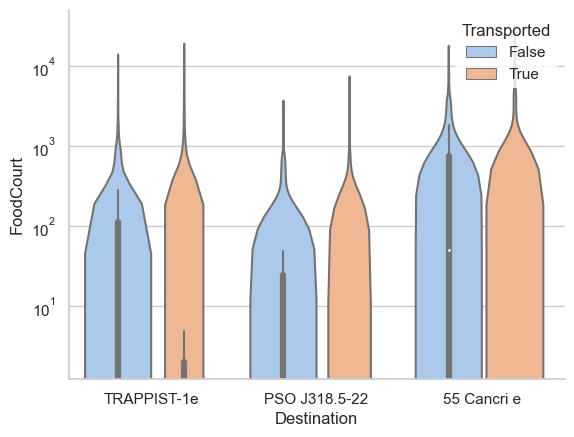

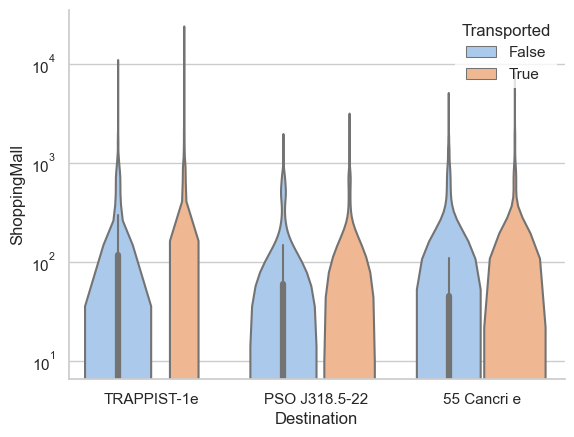

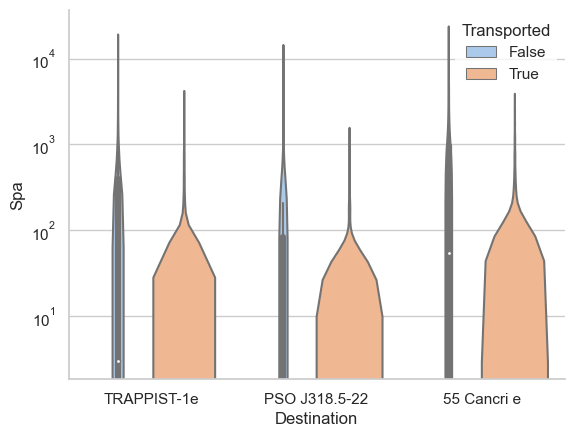

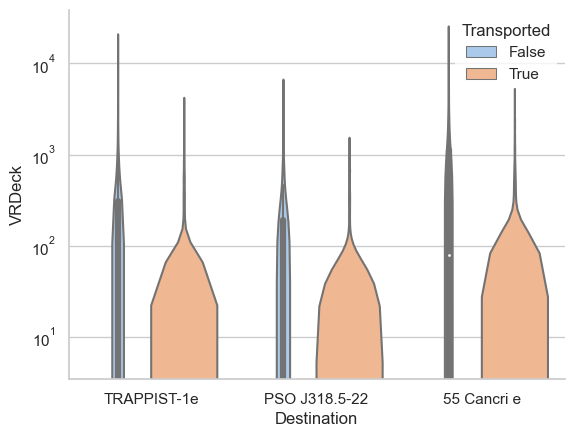

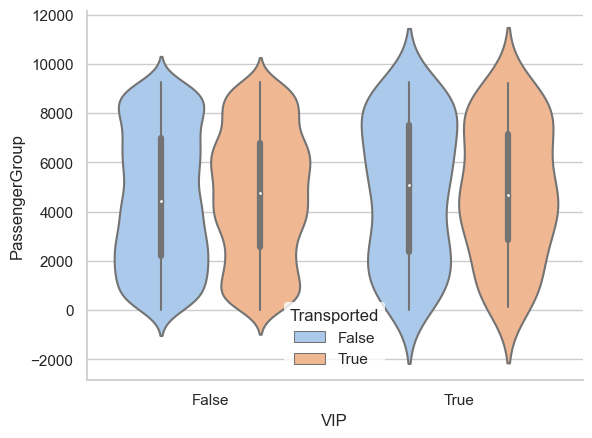

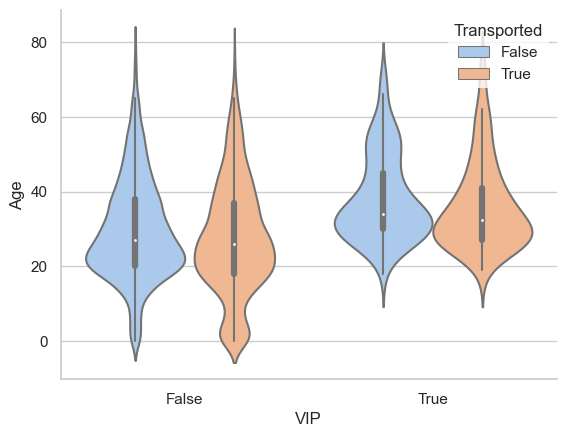

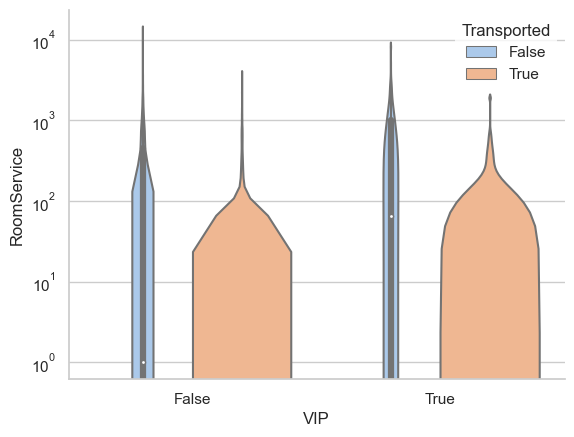

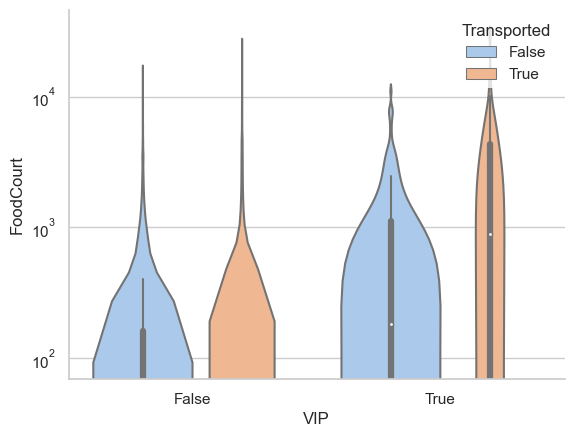

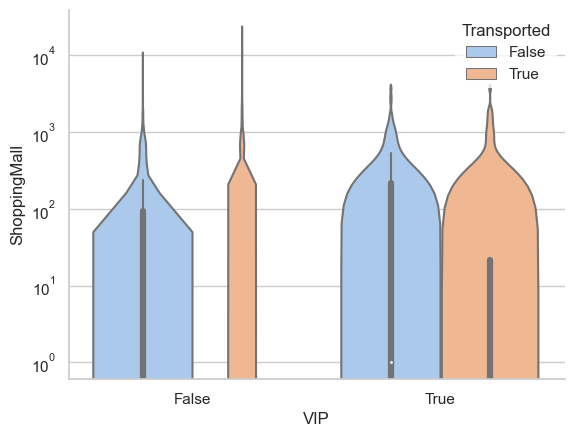

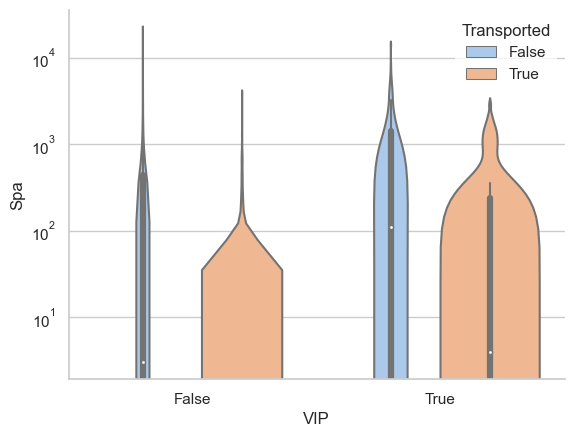

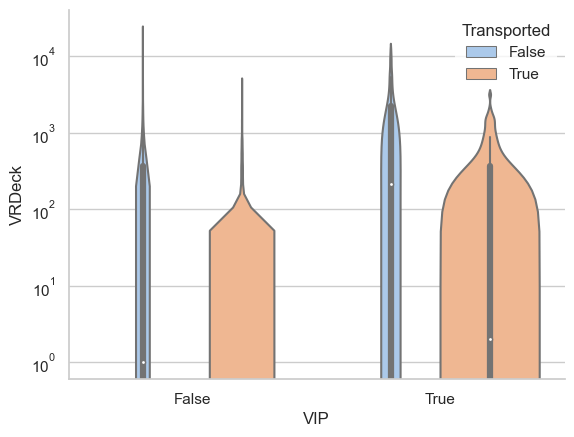

In [236]:
for categorical_feature, numeric_feature in product(
    categorical_features, numerical_features + log_numerical_features
):
    ax = sns.violinplot(data=train, x=categorical_feature, y=numeric_feature, hue=label)
    if numeric_feature in log_numerical_features:
        ax.set(yscale="log")
    plt.show()

# Imputation
## Inference

### Cryosleep
It is suspected and below shown that being in CryoSleep implies that a person will not spend money.
Interestingly, it is not implied that they will not be using VIP.
21 passengers chose to sleep trough their VIP experience.

In [202]:
no_sleep = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
train[no_sleep].isna().sum()

RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
dtype: int64

In [245]:
train.loc[train["CryoSleep"] == True, no_sleep + ["VIP"]].sum()

RoomService     0.0
FoodCourt       0.0
ShoppingMall    0.0
Spa             0.0
VRDeck          0.0
VIP              21
dtype: object

In [240]:
train.loc[train["CryoSleep"] == True, no_sleep] = train.loc[
    train["CryoSleep"] == True, no_sleep
].fillna(0)

In [241]:
train[no_sleep].isna().sum()

RoomService     113
FoodCourt       113
ShoppingMall    112
Spa             118
VRDeck          126
dtype: int64

In [268]:
train.columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported', 'PassengerGroup', 'PassengerNumber', 'FirstName', 'LastName', 'CabinDeck', 'CabinNumber', 'CabinSide', 'GroupSize', 'FamilySize', 'CabinSize'], dtype='object')

In [267]:
train["HomePlanet"].isna().sum()

201

### Passenger Group
Is is assumed and shown below that a Passenger's PassengerGroup implies their HomePlanet.
However, a Passenger's PassengerGroup does not imply destination.
In addition, a Passenger's PassengerGroup does not imply CryoSleep participation.
And while a PassengerGroup may not imply a cabin deck or number, it does imply a side.

In [305]:
train["HomePlanet"].isna().sum()

201

In [283]:
train[["PassengerGroup", "HomePlanet"]].groupby("PassengerGroup").transform(
    "nunique"
).max()

HomePlanet    1
dtype: int64

In [307]:
train["HomePlanet"] = train["HomePlanet"].fillna(
    train[["PassengerGroup", "HomePlanet"]]
    .groupby("PassengerGroup")
    .first()["HomePlanet"]
)
train["HomePlanet"].isna().sum()

74

In [317]:
train[["PassengerGroup", "Destination"]].dropna().groupby("PassengerGroup").transform(
    "nunique"
).max()

Destination    3
dtype: int64

In [314]:
train[["PassengerGroup", "CryoSleep"]].dropna().groupby("PassengerGroup").transform(
    "nunique"
).max()

CryoSleep    2
dtype: int64

In [318]:
train[["PassengerGroup", "CabinDeck"]].dropna().groupby("PassengerGroup").transform(
    "nunique"
).max()

CabinDeck    3
dtype: int64

In [319]:
train[["PassengerGroup", "CabinNumber"]].dropna().groupby("PassengerGroup").transform(
    "nunique"
).max()

CabinNumber    3
dtype: int64

In [320]:
train[["PassengerGroup", "CabinSide"]].dropna().groupby("PassengerGroup").transform(
    "nunique"
).max()

CabinSide    1
dtype: int64

In [321]:
train["CabinSide"] = train["CabinSide"].fillna(
    train[["PassengerGroup", "CabinSide"]]
    .groupby("PassengerGroup")
    .first()["CabinSide"]
)
train["CabinSide"].isna().sum()

70

In [325]:
train[["PassengerGroup", "VIP"]].dropna().groupby("PassengerGroup").transform(
    "nunique"
).max()

VIP    2
dtype: int64

In [322]:
train.isna().sum()

HomePlanet          74
CryoSleep          217
Destination        182
Age                179
VIP                203
RoomService        113
FoodCourt          113
ShoppingMall       112
Spa                118
VRDeck             126
Transported          0
PassengerGroup       0
PassengerNumber      0
FirstName          200
LastName           200
CabinDeck          199
CabinNumber        199
CabinSide           70
GroupSize            0
FamilySize         200
CabinSize          199
dtype: int64

## Clustering